In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, GroupShuffleSplit
import xgboost as xgb


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#Creating Link in Kaggle
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

In [44]:
train_1 = pd.read_csv("../input/jantahack/train_8wry4cB.csv")
test_1 = pd.read_csv('../input/jantahack/test_Yix80N0.csv')

train = train_1.copy()
test = test_1.copy()
print(f"Train : {train.shape}\t Test : {test.shape}")

def date_time(train,test):
    train['startTime'] = pd.to_datetime(train['startTime'])
    train['endTime'] = pd.to_datetime(train['endTime'])

    test['startTime'] = pd.to_datetime(test['startTime'])
    test['endTime'] = pd.to_datetime(test['endTime'])
    
    train['Time_Gap'] = train['endTime']-train['startTime']
    test['Time_Gap'] = test['endTime']-test['startTime']
    
    train['Time_Gap'] = train['Time_Gap'].astype('timedelta64[m]')
    test['Time_Gap'] = test['Time_Gap'].astype('timedelta64[m]')
    
    return train,test

train,test = date_time(train,test)
train['gender'] = train['gender'].map({'female':0,'male':1})

Train : (10500, 5)	 Test : (4500, 4)


In [45]:
def Time_Features(df,col,drop):
    df[col+'_day_'] = df[col].dt.day
    df[col+'_day_of_year'] = df[col].dt.dayofyear
    df[col+'_day_of_week_'] = df[col].dt.dayofweek
    df[col+'_is_month_end'] = (df[col].dt.is_month_end).astype(int)
    
    if drop:
        df.drop([col],axis=1,inplace=True)
    return df

train = Time_Features(train,'startTime',True)
train = Time_Features(train,'endTime',True)

test = Time_Features(test,'startTime',True)
test = Time_Features(test,'endTime',True)

In [46]:
def product_list(train,test):
    train['ProductList'] = [ x.replace(';','') for x in train['ProductList']]
    train['ProductList'] = [x.strip('/') for x in train['ProductList']]
    def fun(x):
        a = pd.Series(str(x).split('/'))
        return a
    data = train.ProductList.apply(fun)
    for i in range(4,144):
        del data[i]
    data = data.rename(columns={0:'Category',1:'Sub_Category',2:'Sub_Sub_Category',3:'Product'})
    train = pd.concat([train,data],axis=1)
    
    # Test DataSet
    test['ProductList'] = [ x.replace(';','') for x in test['ProductList']]
    test['ProductList'] = [x.strip('/') for x in test['ProductList']]
    data = test.ProductList.apply(fun)
    for i in range(4,172):
        del data[i]
    data = data.rename(columns={0:'Category',1:'Sub_Category',2:'Sub_Sub_Category',3:'Product'})
    test = pd.concat([test,data],axis=1)
    
    return train,test

train,test = product_list(train,test)    

In [47]:
del train['ProductList']
del test['ProductList']

In [48]:
def Encoding(df,col):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for i in col:
        df[i] = le.fit_transform(df[i])
    return df
col = ['session_id','Category','Sub_Category','Sub_Sub_Category','Product']
train = Encoding(train,col)
test = Encoding(test,col)

In [49]:
print(f"Train :{train.shape} \t Test:{test.shape}")

Train :(10500, 15) 	 Test:(4500, 14)


In [50]:
train.head()

,session_id,gender,Time_Gap,startTime_day_,startTime_day_of_year,startTime_day_of_week_,startTime_is_month_end,endTime_day_,endTime_day_of_year,endTime_day_of_week_,endTime_is_month_end,Category,Sub_Category,Sub_Sub_Category,Product
0,4324,0,1.0,15,349,0,0,15,349,0,0,1,2,5,6833
1,178,1,6.0,16,350,1,0,16,350,1,0,0,8,30,7015
2,6347,0,0.0,12,12,6,0,12,12,6,0,1,0,19,4359
3,3202,0,3.0,23,327,6,0,23,327,6,0,1,3,17,2802
4,10010,1,2.0,17,351,2,0,17,351,2,0,0,0,11,7273


In [51]:
Y_train = train['gender']
X_train = train.drop(['gender'],axis=1)
kfold = StratifiedKFold(n_splits=10)

In [52]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

print("Classfier \t Accuracy")
for i in range(len(classifiers)):
    model_name =str(classifiers[i]).split("(")[0]
    print(f"{model_name} \t {cv_results[i].max()}")


Classfier 	 Accuracy
SVC 	 0.7819047619047619
DecisionTreeClassifier 	 0.8752380952380953
AdaBoostClassifier 	 0.8761904761904762
RandomForestClassifier 	 0.9019047619047619
ExtraTreesClassifier 	 0.8885714285714286
GradientBoostingClassifier 	 0.8952380952380953
MLPClassifier 	 0.8333333333333334
KNeighborsClassifier 	 0.7933333333333333
LogisticRegression 	 0.780952380952381
LinearDiscriminantAnalysis 	 0.8047619047619048


In [55]:
feat = X_train.columns.to_list()
target = 'gender'

## XGBOOST

--------------------------------------------------------------------------------
Iteration Number  : 1
[20:33:47] WARNING: /workspace/src/learner.cc:328: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-error:0.10476	valid-error:0.10571
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[50]	train-error:0.08042	valid-error:0.08952
[100]	train-error:0.05630	valid-error:0.08571
[150]	train-error:0.03947	valid-error:0.08191
[200]	train-error:0.02889	valid-error:0.08000
[250]	train-error:0.02191	valid-error:0.07905
[300]	train-error:0.01482	valid-error:0.07809
[350]	train-error:0.01069	valid-error:0.07524
[400]	train-error:0.00593	valid-error:0.07429
S

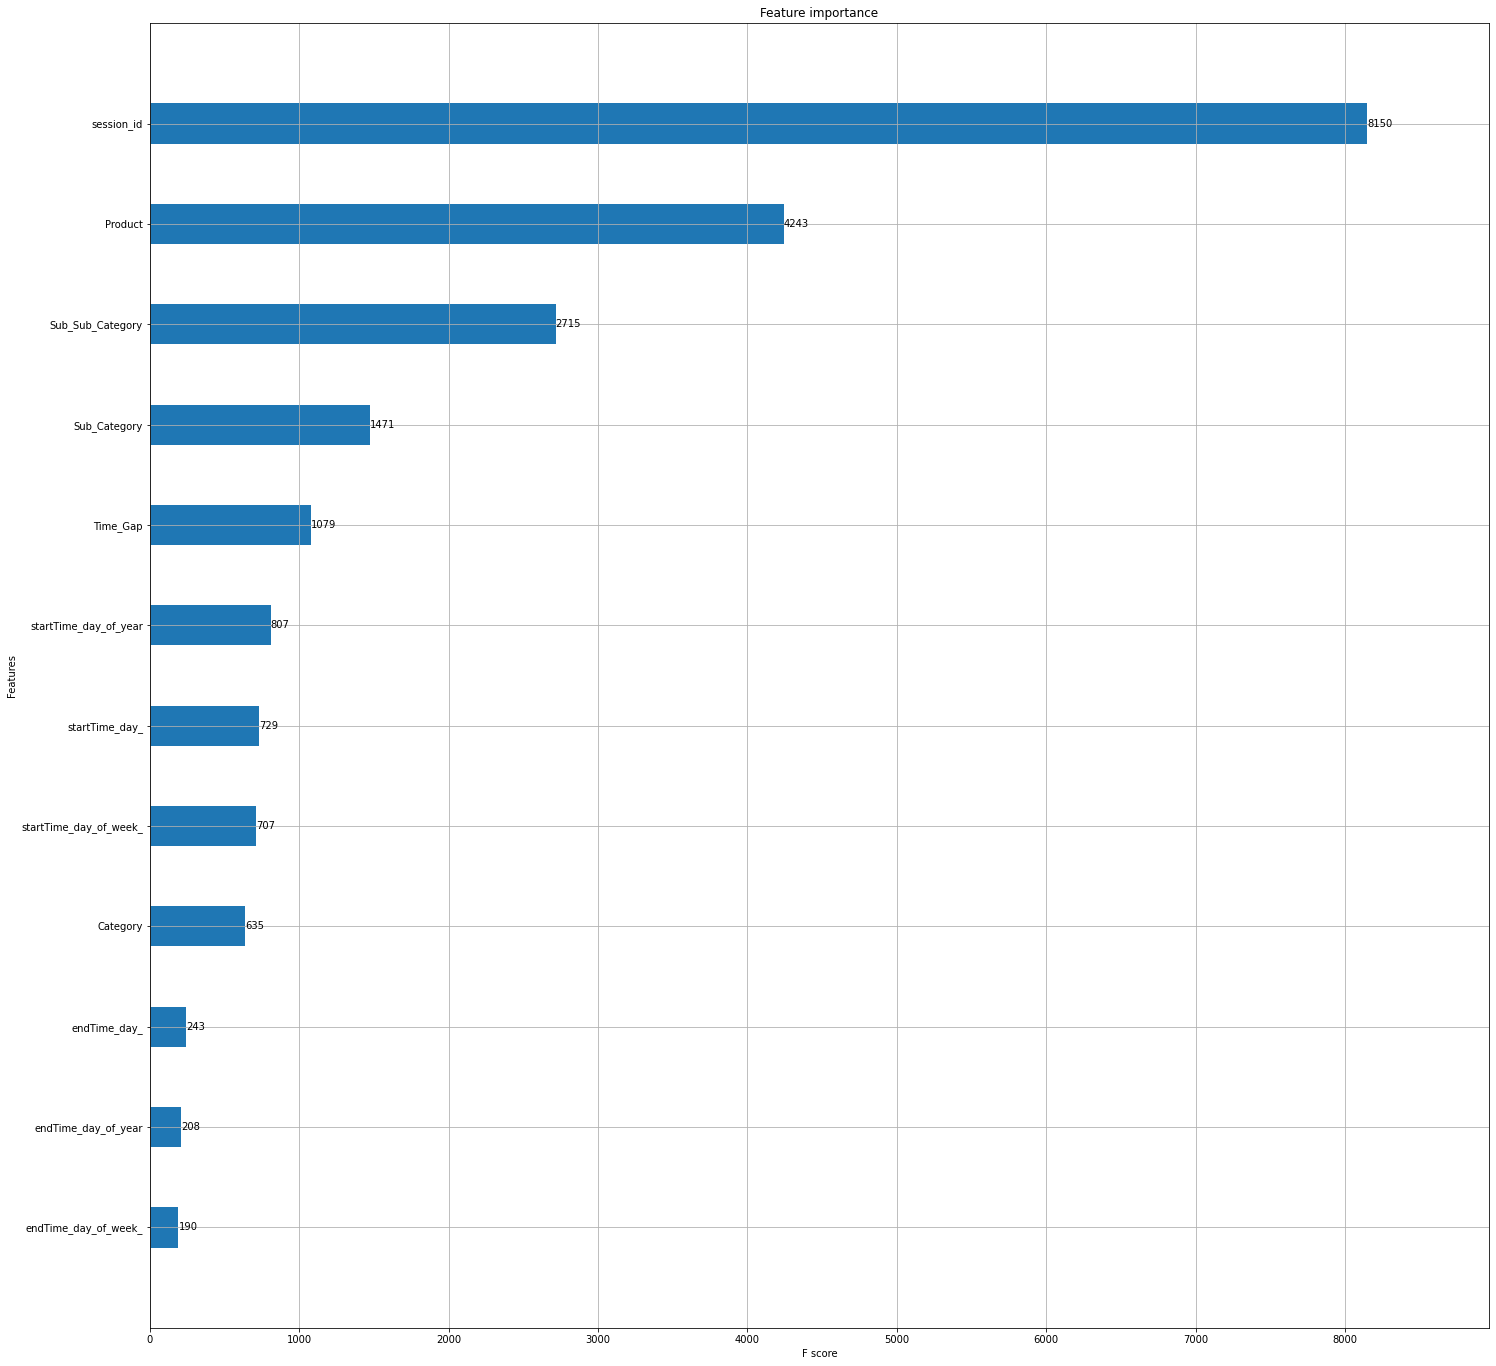

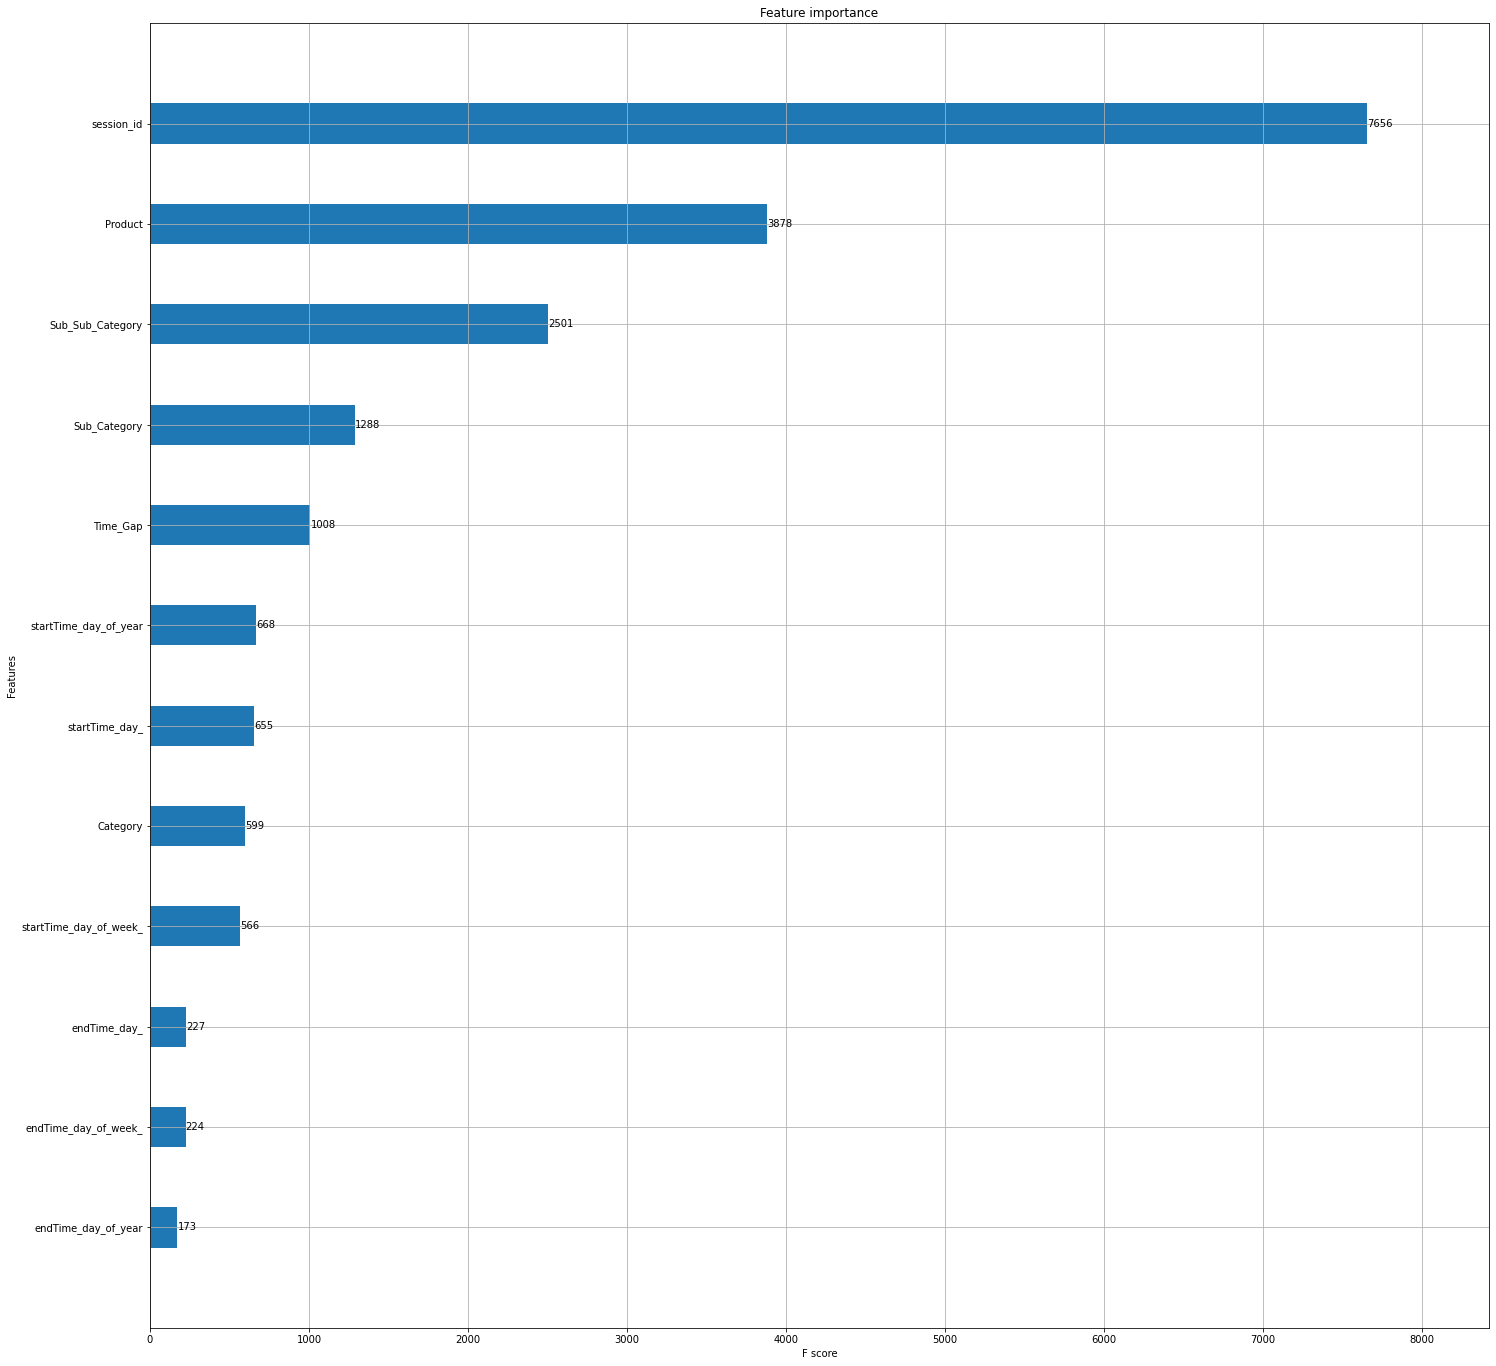

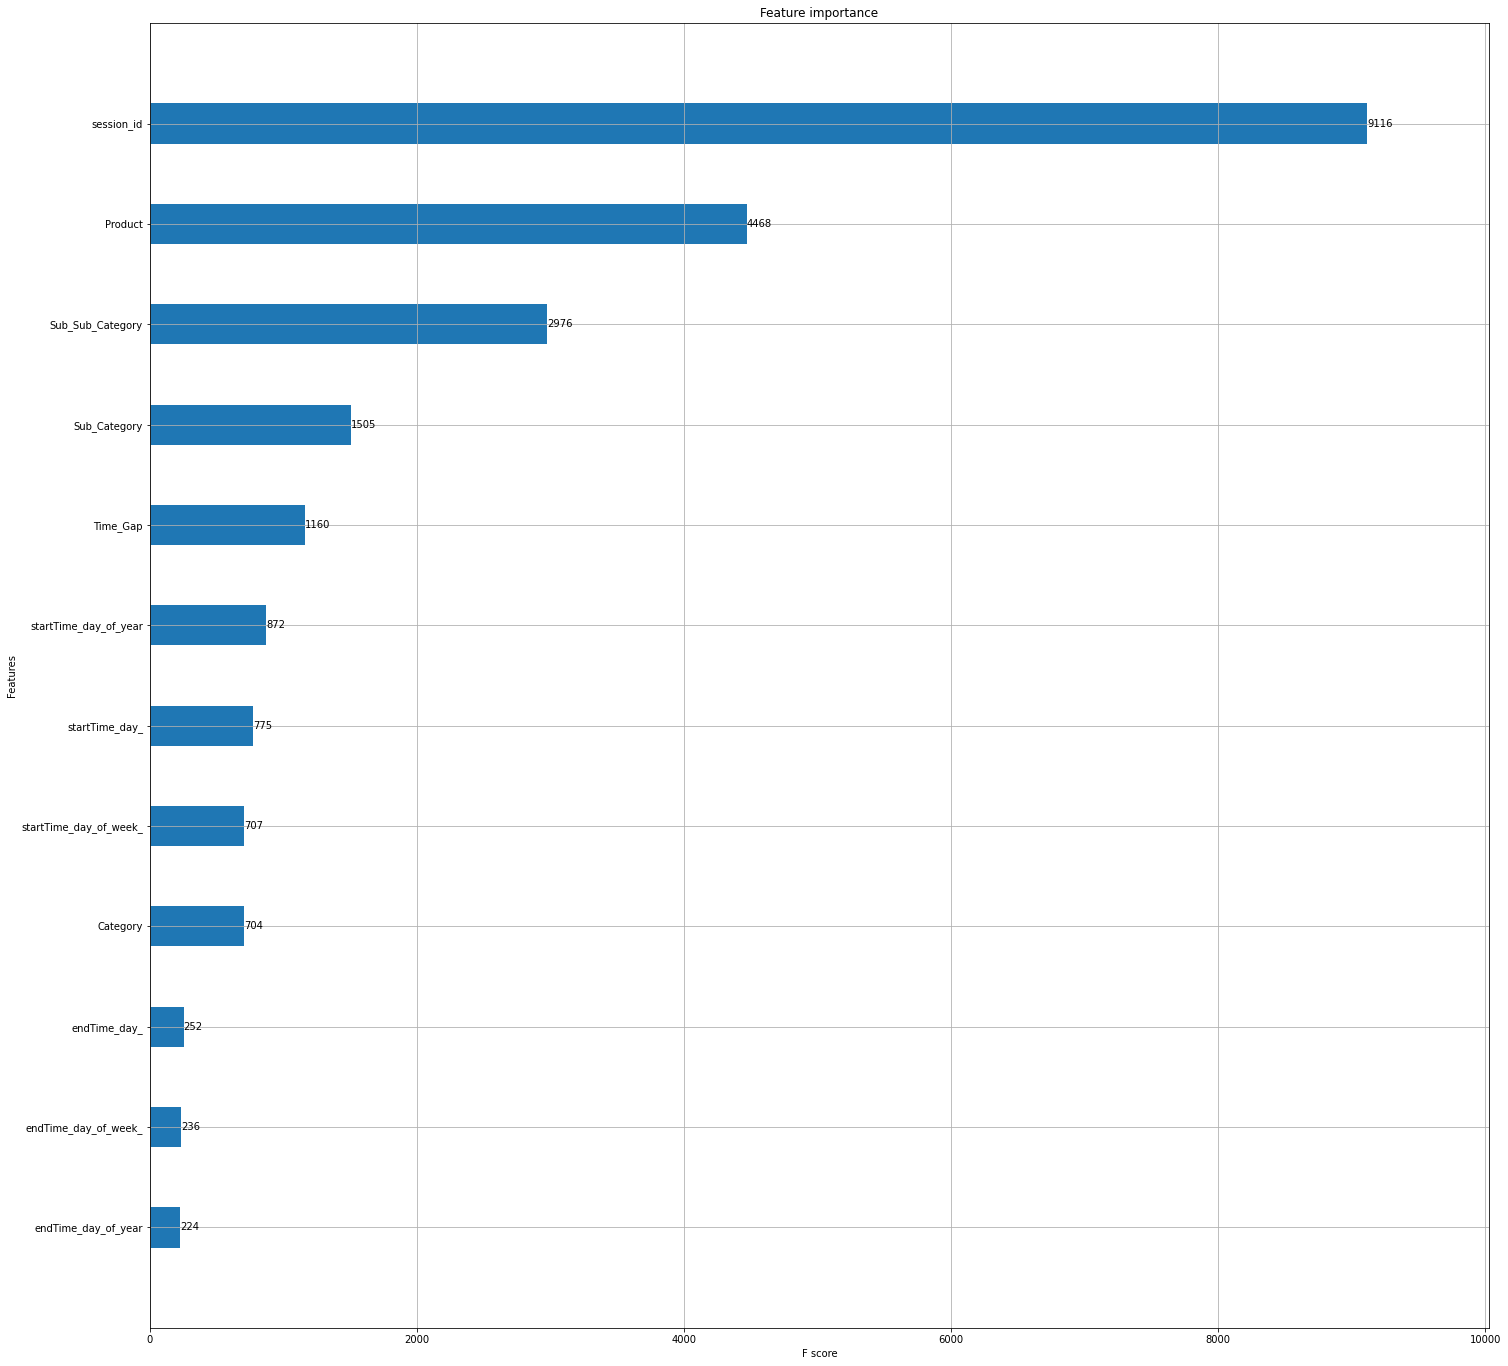

In [58]:
gss = GroupShuffleSplit(n_splits=3, train_size=0.9, random_state=42)
test_prob_preds = np.zeros(test.shape[0])

for idx, (train_idx, valid_idx) in enumerate(gss.split(train[feat], train[target], train['session_id']), 1):
    print("--"*40)
    print("Iteration Number  : {}".format(idx))
    MAX_ROUNDS=2000
    early_stopping_rounds=100
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'learning_rate': 0.1,
        'num_round': MAX_ROUNDS,
        'max_depth': 8,
        'seed': 13,
        'nthread': -1
    }

    X_train, X_valid, y_train, y_valid = train[feat].iloc[train_idx], train[feat].iloc[valid_idx], train[target].iloc[train_idx], train[target].iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(
        params,
        dtrain,
        evals=watchlist,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50
    )
    print("Best Iteration :: {} \n".format(model.best_iteration))

    # Plotting Importances
    fig, ax = plt.subplots(figsize=(24, 24))
    xgb.plot_importance(model, height=0.4, ax=ax)
    preds = model.predict(xgb.DMatrix(test[feat]), ntree_limit=model.best_ntree_limit)
    
    test_prob_preds += preds

test_prob_preds /= gss.n_splits
print(test_prob_preds.shape, test_prob_preds[: 5])
